# Laboratorium 4

Wojciech Kłyszejko i Jan Stobnicki

Zadanie 8 - Kolumnowa rzadka eliminacja Gaussa w formacie CSC

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.sparse import csr_matrix
from time import time

def load_matrix(file_path):
    with open(file_path, "r") as file:
        return np.loadtxt(file, delimiter=",", dtype=np.float64)
    
def enlarge_matrix(m, q):
    size = len(m) * q
    res = np.zeros([size, size], dtype=np.float64)
    for i in range(size):
        for j in range(size):
            res[i, j] = m[i % len(m), j % len(m)]
    return res

def draw_nonzero_values(m):
    figure(figsize=(15, 9), dpi=80)
    plt.spy(m)
    plt.show()

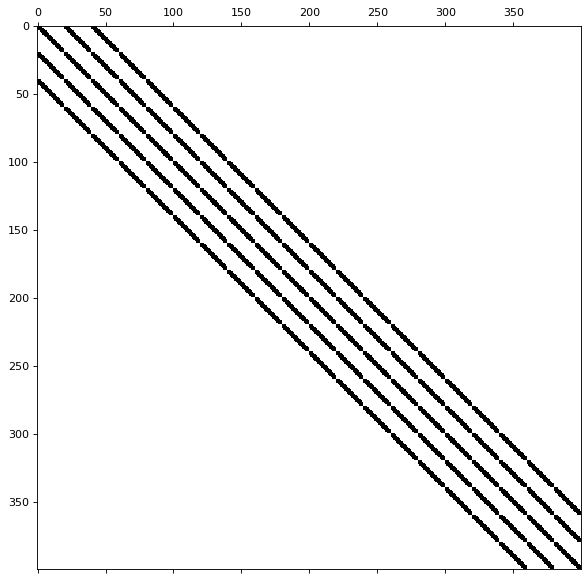

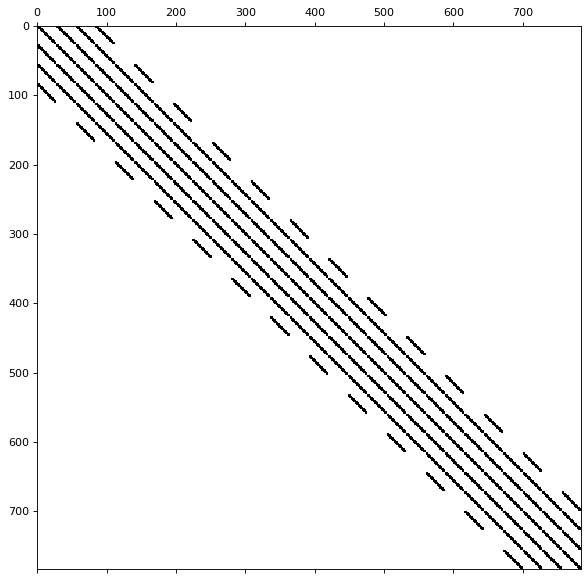

In [33]:
M1 = enlarge_matrix(load_matrix("matrices/mm01820.csv"), 1)
M2 = enlarge_matrix(load_matrix("matrices/mm11330.csv"), 1)

draw_nonzero_values(M1)
draw_nonzero_values(M2)

Eliminacja Gaussa dla macierzy gęstej

In [36]:
def gauss_elimination_dense(A):
    n = np.shape(A)[0]
    B = A.astype(np.float32)
    for i in range(n):
        for j in range(i+1, n):
            r = B[j][i]/B[i][i]
            for k in range(n):
                B[j][k] = B[j][k] - r * B[i][k]
    return B

Kolumnowa rzadka eliminacja Gaussa w formacie CSC

In [38]:
class MyCSC:
    def __init__(self, n, indices = None, values = None, col_ptr = None):
        if not (indices or values or col_ptr):
            self.indices = []
            self.values = []
            self.col_ptr = [0 for _ in range(n + 1)]
            self.n = n
        else:
            self.indices = indices
            self.values = values
            self.col_ptr = col_ptr
            self.n = n

class CSCUtil:
    @staticmethod
    def matrix_to_csc_format(A):
        n = np.shape(A)[0]
        nonzero_values = []
        for col in range(n):
            for row in range(n):
                if A[row][col] != 0:
                    nonzero_values.append((row,col))
        nonzero_row = list(map(lambda e: e[0], nonzero_values))
        nonzero_col = list(map(lambda e: e[1], nonzero_values))
        
        indices = nonzero_row
        values = A[nonzero_row, nonzero_col]
        
        tmp = [0 for i in range(n + 1)]
        for e in nonzero_col:
            tmp[e + 1] += 1
        for i in range(1, len(tmp)):
            tmp[i] += tmp[i - 1]
            
        col_ptr = np.array(tmp)
            
        return MyCSC(n, indices, values, col_ptr)
      
    @staticmethod
    def gauss_elimination_sparse(A):
        res = np.zeros(shape = (A.n, A.n), dtype=np.float64)
        cur_matrix = A
        for k in range(A.n - 1):
            next_matrix = MyCSC(A.n)
            
            # get index of Akk
            akk_val = None
            akk_idx = None
            for x in range(cur_matrix.col_ptr[k] , cur_matrix.col_ptr[k + 1]):
                res[cur_matrix.indices[x], k] = cur_matrix.values[x]
                if cur_matrix.indices[x] < k:
                    res[cur_matrix.indices[x], k] = cur_matrix.values[x]
                elif cur_matrix.indices[x] == k:
                    res[cur_matrix.indices[x], k] = cur_matrix.values[x]
                    akk_idx = x
                    akk_val = cur_matrix.values[x]
                else:
                    break
            if akk_idx == None:
                raise Exception("zerowa wartosc na przekatnej")
                
            for j in range(k + 1, A.n):
                new_j_col_idx = []
                new_j_col_vals = []
                
                j_col_k_row_idx = None
                for i in range(cur_matrix.col_ptr[j], cur_matrix.col_ptr[j + 1]):
                    new_j_col_idx.append(cur_matrix.indices[i])
                    new_j_col_vals.append(cur_matrix.values[i])
                    if cur_matrix.indices[i] == k:
                        j_col_k_row_idx = i
                        break
                     
                    
                if j_col_k_row_idx:
                    k_idx = akk_idx + 1
                    j_idx = j_col_k_row_idx + 1
                    while k_idx < cur_matrix.col_ptr[k + 1] and j_idx < cur_matrix.col_ptr[j + 1] :
                        k_row = cur_matrix.indices[k_idx]
                        j_row = cur_matrix.indices[j_idx]
                        k_row_val = cur_matrix.values[k_idx]
                        j_row_val = cur_matrix.values[j_idx]
                        
                        if k_row == j_row:
                            new_val = j_row_val - (k_row_val / akk_val) * cur_matrix.values[j_col_k_row_idx]
                            if abs(new_val) > 10**-6:
                                new_j_col_idx.append(j_row)
                                new_j_col_vals.append(new_val)
                            k_idx += 1
                            j_idx += 1
                        elif k_row < j_row:
                            new_val = - (k_row_val / akk_val) * cur_matrix.values[j_col_k_row_idx]
                            if abs(new_val) > 10**-6:
                                new_j_col_idx.append(j_row)
                                new_j_col_vals.append(new_val)
                            k_idx += 1
                        else:
                            if abs(j_row_val) > 10**-6:
                                new_j_col_idx.append(j_row)
                                new_j_col_vals.append(j_row_val)
                            j_idx += 1
                        
                    while j_idx < cur_matrix.col_ptr[j + 1] :
                        j_row = cur_matrix.indices[j_idx]
                        j_row_val = cur_matrix.values[j_idx]
                        
                        if abs(j_row_val) > 10**-6:
                            new_j_col_idx.append(j_row)
                            new_j_col_vals.append(j_row_val)
                        j_idx += 1
                        
                # wstawic do nowej macierzy nową j-tą kolumnę:
#                 print("k = ",k , "j = ", j)
#                 print(" new j col: " , new_j_col_idx)
#                 print(" new j val: " , new_j_col_vals)
                next_matrix.indices.extend(new_j_col_idx)
                next_matrix.values.extend(new_j_col_vals)
                next_matrix.col_ptr[j + 1] = next_matrix.col_ptr[j] + len(new_j_col_idx)
            #end for j
            cur_matrix = next_matrix
#             print("RES")
#             print(res)
            
        #lastly write last column to resulting matrix
#         print("next matrix:")
#         print(next_matrix.values)
        for ab in range(next_matrix.col_ptr[A.n - 1],next_matrix.col_ptr[A.n]):
            res[next_matrix.indices[ab], -1] = next_matrix.values[ab]
        return res

In [39]:
def verify(a, b):
    n = np.shape(a)[0]
    wrong = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(n):
            if abs(a[i, j] - b[i, j]) > 10**-1:
                wrong[i, j] = 1
                print("is: ", b[i, j], "should be: ", a[i, j])
                raise Exception("cipa")
    return wrong

Testy i mierzenie czasu:

In [44]:
def timetest(M, el_type):
    start_time = time()
    C = None
    if el_type == "dense":
        C = gauss_elimination_dense(M)
    elif el_type == "sparse":
        m_csc = CSCUtil.matrix_to_csc_format(M)
        C = CSCUtil.gauss_elimination_sparse(m_csc)
    res = time() - start_time
    return res, C


def get_average_mul_time(M, trial_number):
    print(f"M: {len(M)}x{len(M)}")
    total_time_dense = total_time_sparse = 0
    for i in range(trial_number):
        
        test_dense_i, res_dense = timetest(M, "dense")
        test_sparse_i, res_sparse = timetest(M, "sparse")
        
        verify(res_dense, res_sparse)
        print(f"i = {i + 1}| dense: {test_dense_i}\n     | sparse: {test_sparse_i}")
        total_time_dense += test_dense_i
        total_time_sparse += test_sparse_i
    print("Avg time for dense elimination is: " + str(total_time_dense / trial_number) + " seconds")
    print("Avg time for sparse elimination is: " + str(total_time_sparse / trial_number) + " seconds")
    draw_nonzero_values(res_sparse)
    print()

M: 400x400
i = 1| dense: 16.969093084335327
     | sparse: 0.2537977695465088
i = 2| dense: 17.075859308242798
     | sparse: 0.26754283905029297
i = 3| dense: 16.948424577713013
     | sparse: 0.25577497482299805
Avg time for dense elimination is: 16.997792323430378 seconds
Avg time for sparse elimination is: 0.2590385278065999 seconds


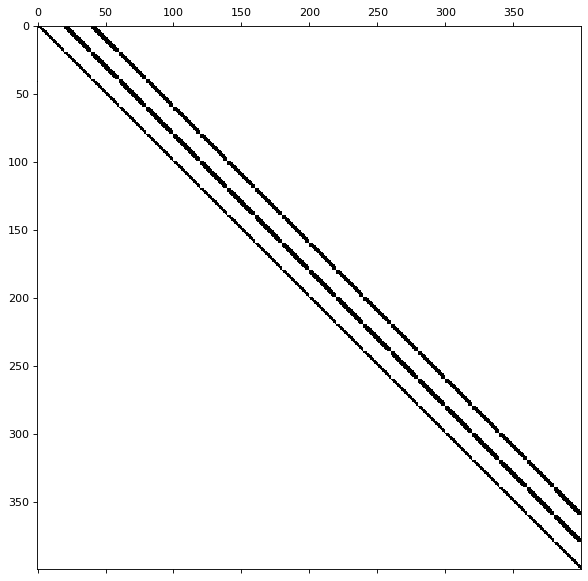

In [45]:
get_average_mul_time(M1, 3)

M: 784x784
i = 1| dense: 164.37271237373352
     | sparse: 2.7702200412750244
i = 2| dense: 163.2164032459259
     | sparse: 2.8727996349334717
i = 3| dense: 159.61338019371033
     | sparse: 2.5671255588531494
Avg time for dense elimination is: 162.40083193778992 seconds
Avg time for sparse elimination is: 2.736715078353882 seconds


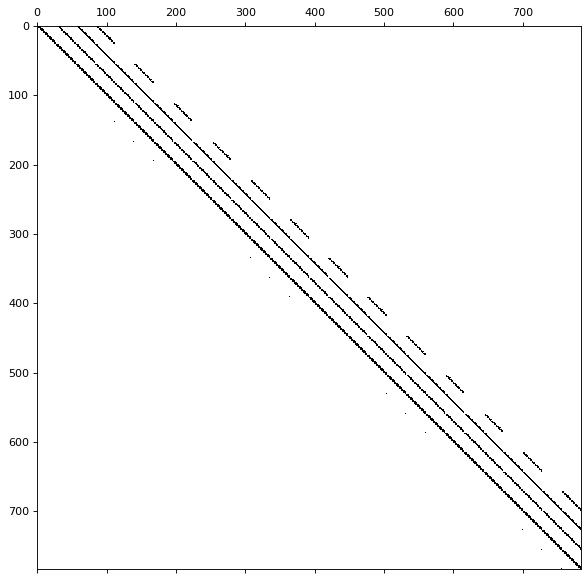

In [46]:
get_average_mul_time(M2, 3)